In [1]:
import sys
import json
import pickle
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
from PIL import Image
import math
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf
torch.set_grad_enabled(False)

sys.path.append('../')
from models.library import qres34m

In [2]:
device = torch.device('cuda:0')
weights_root = Path('../checkpoints/qres34m')

# initialize model
lmb = 2048
model = qres34m(lmb=lmb)
wpath = weights_root / f'lmb{lmb}/last_ema.pt'
msd = torch.load(wpath)['model']
model.load_state_dict(msd)

model = model.to(device=device)
model.eval()
print(f'Using lmb={lmb}. Model weights={wpath}')

Using lmb=2048. Model weights=..\checkpoints\qres34m\lmb2048\last_ema.pt


In [5]:
impath = Path('../images/collie128.png')
im = im = tvf.to_tensor(Image.open(impath)).unsqueeze_(0).to(device=device)
nB, imC, imH, imW = im.shape

stats_all = model.forward_get_latents(im)

progressive_decodings = []
L = len(stats_all)
for keep in range(1, L+1):
    latents = [stat['z'] if (i < keep) else None for (i,stat) in enumerate(stats_all)]
    kl_divs = [stat['kl'] for (i,stat) in enumerate(stats_all) if (i < keep)]
    kl = sum([kl.sum(dim=(1,2,3)) for kl in kl_divs]) / (imH * imW) * math.log2(math.e)
    sample = model.cond_sample(latents, temprature=0)
    progressive_decodings.append(sample.squeeze(0))
    print(f'Keep={keep}, bpp={kl.item()}')
progressive_decodings = torch.stack(progressive_decodings, dim=0)

Keep=1, bpp=0.010392916388809681
Keep=2, bpp=0.04203978553414345
Keep=3, bpp=0.0720185711979866
Keep=4, bpp=0.22937768697738647
Keep=5, bpp=0.3684685230255127
Keep=6, bpp=0.5078673362731934
Keep=7, bpp=1.155739188194275
Keep=8, bpp=1.6931045055389404
Keep=9, bpp=2.0948104858398438
Keep=10, bpp=3.430553436279297
Keep=11, bpp=4.988546371459961
Keep=12, bpp=5.492160797119141


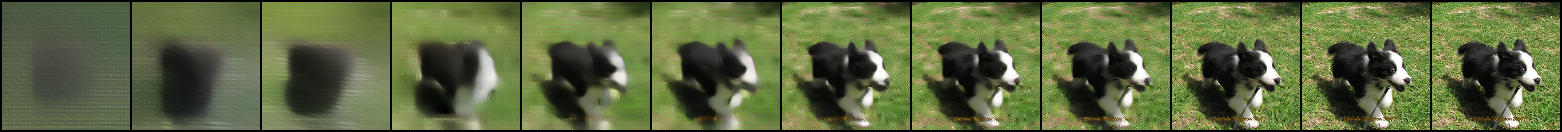

In [9]:
im = tv.utils.make_grid(progressive_decodings, nrow=12)
tvf.to_pil_image(im)
